# 학습 방법 - Scene

3개의 Scene에 대해서 각각 따로 학습

user별로 학습을 하지 않는 이유는 상관관계로 보았을 때 user끼리는 달라도 scene별로는 유사점이 꽤 보였기 때문.

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = '1122-User1-LSTM-win48'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('user1*_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('user1*_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 48

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(6491, 6511)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([48, 6]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([48, 6])

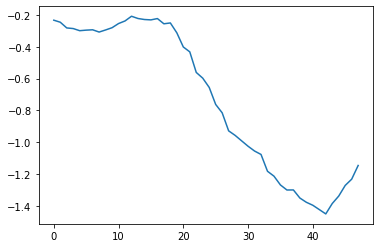

In [10]:
plt.plot(x[:, 2])

# 모델 생성

StackedLSTM Bidirectional

In [11]:
model = utils.BaselineLSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           dropout=0.2,
                           bidirectional=True).cuda()

In [12]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [13]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [14]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [15]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [17]:
trainer.fit(ds_train, ds_test, start_epoch=101, num_epochs=200, batch_size=256, shuffle=True, pin_memory=True)

[0102/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.025319
 - Pitch        :   0.947329
 - Roll         :   0.783205
 - RMS          :   0.924143
 - 99% Tile     :   6.475887
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0101.npy


[0103/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.005704
 - Pitch        :   0.883201
 - Roll         :   0.811109
 - RMS          :   0.903582
 - 99% Tile     :   5.885122
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0102.npy


[0104/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.987185
 - Pitch        :   0.876098
 - Roll         :   0.771595
 - RMS          :   0.882693
 - 99% Tile     :   5.950819
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0103.npy


[0105/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.027060
 - Pitch        :   0.951716
 - Roll         :   0.746850
 - RMS          :   0.916224
 - 99% Tile     :   6.143341
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0104.npy


[0106/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.068212
 - Pitch        :   0.955216
 - Roll         :   0.761916
 - RMS          :   0.937022
 - 99% Tile     :   6.032609
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0105.npy


[0107/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.960654
 - Pitch        :   0.938360
 - Roll         :   0.762464
 - RMS          :   0.891577
 - 99% Tile     :   5.950626
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0106.npy


[0108/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.949082
 - Pitch        :   0.942645
 - Roll         :   0.777301
 - RMS          :   0.893222
 - 99% Tile     :   6.196268
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0107.npy


[0109/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.972207
 - Pitch        :   0.929081
 - Roll         :   0.746649
 - RMS          :   0.888043
 - 99% Tile     :   6.225287
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0108.npy


[0110/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.927137
 - Pitch        :   0.931697
 - Roll         :   0.758719
 - RMS          :   0.876222
 - 99% Tile     :   6.267821
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0109.npy


[0111/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.953342
 - Pitch        :   0.916526
 - Roll         :   0.739356
 - RMS          :   0.874744
 - 99% Tile     :   6.316571
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0110.npy


[0112/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.927980
 - Pitch        :   0.907963
 - Roll         :   0.758793
 - RMS          :   0.868199
 - 99% Tile     :   6.286962
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0111.npy


[0113/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.894019
 - Pitch        :   0.917878
 - Roll         :   0.757077
 - RMS          :   0.859251
 - 99% Tile     :   6.277755
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0112.npy


[0114/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.906498
 - Pitch        :   0.924271
 - Roll         :   0.752993
 - RMS          :   0.864680
 - 99% Tile     :   6.379351
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0113.npy


[0115/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.937028
 - Pitch        :   0.926555
 - Roll         :   0.753217
 - RMS          :   0.876330
 - 99% Tile     :   6.272123
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0114.npy


[0116/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.992275
 - Pitch        :   0.949549
 - Roll         :   0.746445
 - RMS          :   0.902484
 - 99% Tile     :   6.266891
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0115.npy


[0117/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.886391
 - Pitch        :   0.879609
 - Roll         :   0.763493
 - RMS          :   0.845049
 - 99% Tile     :   6.229323
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0116.npy


[0118/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.895162
 - Pitch        :   0.903451
 - Roll         :   0.759253
 - RMS          :   0.855181
 - 99% Tile     :   6.224718
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0117.npy


[0119/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.909375
 - Pitch        :   0.877178
 - Roll         :   0.742420
 - RMS          :   0.846087
 - 99% Tile     :   6.160227
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0118.npy


[0120/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.891410
 - Pitch        :   0.877799
 - Roll         :   0.762099
 - RMS          :   0.845761
 - 99% Tile     :   6.210739
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0119.npy


[0121/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.896502
 - Pitch        :   0.883354
 - Roll         :   0.759687
 - RMS          :   0.848755
 - 99% Tile     :   6.221454
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0120.npy


[0122/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.919941
 - Pitch        :   0.892295
 - Roll         :   0.729766
 - RMS          :   0.851477
 - 99% Tile     :   6.147093
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0121.npy


[0123/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.884297
 - Pitch        :   0.859178
 - Roll         :   0.758042
 - RMS          :   0.835623
 - 99% Tile     :   6.201392
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0122.npy


[0124/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.909960
 - Pitch        :   0.862306
 - Roll         :   0.754625
 - RMS          :   0.844799
 - 99% Tile     :   6.169215
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0123.npy


[0125/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.959434
 - Pitch        :   1.009450
 - Roll         :   0.766750
 - RMS          :   0.917861
 - 99% Tile     :   6.296568
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0124.npy


[0126/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.984585
 - Pitch        :   0.871469
 - Roll         :   0.759238
 - RMS          :   0.876605
 - 99% Tile     :   6.161611
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0125.npy


[0127/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.898939
 - Pitch        :   0.901097
 - Roll         :   0.728764
 - RMS          :   0.846791
 - 99% Tile     :   6.130563
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0126.npy


[0128/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.893063
 - Pitch        :   0.888323
 - Roll         :   0.736294
 - RMS          :   0.842379
 - 99% Tile     :   6.096318
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0127.npy


[0129/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.932769
 - Pitch        :   0.940969
 - Roll         :   0.737346
 - RMS          :   0.875435
 - 99% Tile     :   6.099455
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0128.npy


[0130/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.964960
 - Pitch        :   0.889775
 - Roll         :   0.723405
 - RMS          :   0.865286
 - 99% Tile     :   6.129209
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0129.npy


[0131/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.870254
 - Pitch        :   0.908333
 - Roll         :   0.724435
 - RMS          :   0.838096
 - 99% Tile     :   6.104389
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0130.npy


[0132/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.886206
 - Pitch        :   0.901085
 - Roll         :   0.743033
 - RMS          :   0.846446
 - 99% Tile     :   6.154407
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0131.npy


[0133/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.890049
 - Pitch        :   0.886828
 - Roll         :   0.732328
 - RMS          :   0.839634
 - 99% Tile     :   6.185386
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0132.npy


[0134/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.882861
 - Pitch        :   0.922061
 - Roll         :   0.731600
 - RMS          :   0.849486
 - 99% Tile     :   6.141522
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0133.npy


[0135/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.960852
 - Pitch        :   0.908986
 - Roll         :   0.739736
 - RMS          :   0.874967
 - 99% Tile     :   6.127345
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0134.npy


[0136/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.927915
 - Pitch        :   0.850152
 - Roll         :   0.721960
 - RMS          :   0.837658
 - 99% Tile     :   6.152500
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0135.npy


[0137/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.861654
 - Pitch        :   0.888426
 - Roll         :   0.717037
 - RMS          :   0.825811
 - 99% Tile     :   6.078174
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0136.npy


[0138/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.863396
 - Pitch        :   0.871451
 - Roll         :   0.715830
 - RMS          :   0.820019
 - 99% Tile     :   6.131066
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0137.npy


[0139/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.891130
 - Pitch        :   0.837874
 - Roll         :   0.733654
 - RMS          :   0.823487
 - 99% Tile     :   6.107553
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0138.npy


[0140/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.880860
 - Pitch        :   0.897007
 - Roll         :   0.724612
 - RMS          :   0.837775
 - 99% Tile     :   6.039370
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0139.npy


[0141/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.833492
 - Pitch        :   0.906433
 - Roll         :   0.731241
 - RMS          :   0.826850
 - 99% Tile     :   6.080028
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0140.npy


[0142/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.889234
 - Pitch        :   0.921463
 - Roll         :   0.733874
 - RMS          :   0.852135
 - 99% Tile     :   6.127960
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0141.npy


[0143/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.895042
 - Pitch        :   0.879554
 - Roll         :   0.748771
 - RMS          :   0.843677
 - 99% Tile     :   6.111584
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0142.npy


[0144/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.898924
 - Pitch        :   0.871579
 - Roll         :   0.727926
 - RMS          :   0.836180
 - 99% Tile     :   6.097889
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0143.npy


[0145/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.882081
 - Pitch        :   0.835481
 - Roll         :   0.721139
 - RMS          :   0.815707
 - 99% Tile     :   6.104466
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0144.npy


[0146/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.879777
 - Pitch        :   0.858330
 - Roll         :   0.719191
 - RMS          :   0.822187
 - 99% Tile     :   6.088878
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0145.npy


[0147/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.889624
 - Pitch        :   0.846999
 - Roll         :   0.729897
 - RMS          :   0.824942
 - 99% Tile     :   6.058104
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0146.npy


[0148/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.908803
 - Pitch        :   0.854249
 - Roll         :   0.731547
 - RMS          :   0.834830
 - 99% Tile     :   6.102863
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0147.npy


[0149/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.910483
 - Pitch        :   0.850584
 - Roll         :   0.723322
 - RMS          :   0.831799
 - 99% Tile     :   6.107881
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0148.npy


[0150/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.843085
 - Pitch        :   0.883091
 - Roll         :   0.729392
 - RMS          :   0.821108
 - 99% Tile     :   6.092914
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0149.npy


[0151/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.875947
 - Pitch        :   0.864319
 - Roll         :   0.723416
 - RMS          :   0.824148
 - 99% Tile     :   6.089805
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0150.npy


[0152/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.881109
 - Pitch        :   0.870044
 - Roll         :   0.720540
 - RMS          :   0.827145
 - 99% Tile     :   6.111489
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0151.npy


[0153/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.851575
 - Pitch        :   0.880572
 - Roll         :   0.723041
 - RMS          :   0.821254
 - 99% Tile     :   6.077283
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0152.npy


[0154/0200] Train:   0%|                                                     | 0/26 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.875185
 - Pitch        :   0.892720
 - Roll         :   0.728167
 - RMS          :   0.835290
 - 99% Tile     :   6.073177
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0153.npy


[0154/0200] Validation: 100%|██████████████████████| 26/26 [00:01<00:00, 21.47it/s, val_loss 2.1492]

Decaying lr from 6.25e-05 to 3.125e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.870978
 - Pitch        :   0.879057
 - Roll         :   0.720188
 - RMS          :   0.826643
 - 99% Tile     :   6.066216
Save output signals into checkpoint/1122-User1-LSTM-win48/sample/0154.npy
